# Train using pure SGD, one record used to compute gradient

This notebook is part of article [Explaining RNNs without neural networks](https://explained.ai/rnn/index.html) and notebook [prep.ipynb](prep.ipynb) should be run this before notebook as it needs files: `data/X.pkl` and `data/y.pkl`.

## Load X, y

In [8]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

!if ! test -f support.py; then wget https://raw.githubusercontent.com/parrt/ml-articles/master/rnn/notebooks/support.py; fi
    
from support import *

In [9]:
import pickle
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)
with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

## Split out validation set

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

In [11]:
def forward1(x):
    h = torch.zeros(nhidden, 1, dtype=torch.float64, requires_grad=False)  # reset hidden state at start of record
    for j in range(len(x)):  # for each char in a name
        x_onehot = onehot(x[j])
        h = W.mm(h) + U.mm(x_onehot)# + b
        h = torch.tanh(h)
    # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
    # run through a final layer to map that h to a one-hot encoded predicted class
    o = V.mm(h)# + Vb
    o = o.reshape(1,nclasses)
    o = softmax(o)
    return o

def forward(X:Sequence[Sequence]):#, apply_softmax=True):
    "Cut-n-paste from body of training for use with metrics"
    outputs = []
    for i in range(0, len(X)): # for each input record
        o = forward1(X[i])
        outputs.append( o[0] ) 
    return torch.stack(outputs)

## Setup

Just some matrices. First, set up hyper parameters:

In [12]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

In [13]:
vocab, ctoi = getvocab(X)

In [14]:
def onehot(c) -> torch.tensor:
    v = torch.zeros((len(vocab),1), dtype=torch.float64)
    v[ctoi[c]] = 1
    return v

In [15]:
nhidden = 100
nfeatures = len(vocab)
nclasses = len(torch.unique(y_train))
n = len(X_train)
print(f"{n:,d} training records, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

10,699 training records, 29 features (chars), 18 target languages, state is 100-vector


## Train using pure SGD, one record used to compute gradient

Epoch:   1 accum loss  1.8742 accur 0.575 | train loss  1.2999 accur 0.636 | valid loss  1.4207 accur 0.630
Epoch:   2 accum loss  1.3088 accur 0.635 | train loss  1.0727 accur 0.693 | valid loss  1.2236 accur 0.675
Epoch:   3 accum loss  1.2185 accur 0.657 | train loss  1.1175 accur 0.681 | valid loss  1.2636 accur 0.664
Epoch:   4 accum loss  1.1140 accur 0.683 | train loss  0.9836 accur 0.717 | valid loss  1.1559 accur 0.698
Epoch:   5 accum loss  1.0582 accur 0.694 | train loss  0.9160 accur 0.735 | valid loss  1.1103 accur 0.719
Epoch:   6 accum loss  0.9934 accur 0.712 | train loss  0.9292 accur 0.731 | valid loss  1.1047 accur 0.708
Epoch:   7 accum loss  0.9440 accur 0.721 | train loss  0.8494 accur 0.755 | valid loss  1.0306 accur 0.735
Epoch:   8 accum loss  0.9206 accur 0.725 | train loss  0.8619 accur 0.754 | valid loss  1.0738 accur 0.738
Epoch:   9 accum loss  0.8851 accur 0.737 | train loss  0.8164 accur 0.761 | valid loss  1.0152 accur 0.737
Epoch:  10 accum loss  0.878

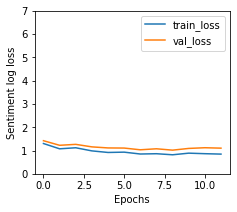

CPU times: user 3min 21s, sys: 3.13 s, total: 3min 24s
Wall time: 3min 27s


In [16]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden,    nhidden,   dtype=torch.float64, requires_grad=True)
U = torch.randn(nhidden,  nfeatures, dtype=torch.float64, requires_grad=True) # embed one-hot char vec
V = torch.randn(nclasses, nhidden,   dtype=torch.float64, requires_grad=True) # take RNN output (h) and predict target

optimizer = torch.optim.Adam([W,U,V], lr=0.001, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    for i in range(0, n): # an epoch trains all input records
        x = X_train[i]
        h = torch.zeros(nhidden, 1, dtype=torch.float64, requires_grad=False)  # reset hidden state at start of record
        for j in range(len(x)):  # for each char in a name
            h = W.mm(h) + U.mm(onehot(x[j]))
            h = torch.tanh(h)
        # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
        # run through a final layer to map that h to a one-hot encoded predicted class
#         h = dropout(h, p=0.3)
        o = V.mm(h)
        o = o.reshape(1,nclasses)
        o = softmax(o)

        loss = cross_entropy(o, y_train[i])
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

#         print(loss.item())

        epoch_training_loss += loss.detach().item()
        correct = torch.argmax(o[0])==y_train[i]
        epoch_training_accur += correct

    epoch_training_loss /= n
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train)
        correct = torch.argmax(o, dim=1).detach()==y_train
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid)
        valid_loss = cross_entropy(o, y_valid)
        correct = torch.argmax(o, dim=1).detach()==y_valid
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

Timing on 80% training from full data set:

```
CPU times: user 4min 51s, sys: 2.91 s, total: 4min 54s
Wall time: 4min 53s
```